라이브러리

In [1]:
import pandas as pd
import numpy as np
from keras.utils import *
from sklearn.preprocessing import *
from keras import backend as K
from keras.models import load_model
from keras.layers import LSTM, Dense
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.font_manager as fm
from matplotlib.dates import DateFormatter
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# 모델명(= 파일명) 설정
model_name = 'test230419-02_LSTMJaponicaWater'

# 한글 글꼴 경로 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # 원하는 한글 글꼴 파일 경로로 수정해주세요
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [2]:
# r_squared 평가 함수
def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - ss_res/(ss_tot + K.epsilon()))

# 모델 평가 함수
def grapeNEva(model, X_test_shape, y_test):
    X_pred = model.predict(X_test_shape)

    # 그래프 생성
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='actual')  # x축에 년월일, y축에 값
    plt.plot(y_test.index, X_pred, color='red', label='prediction')  # x축에 년월일, y축에 시분
    plt.xlabel('날짜')
    plt.ylabel('prediction')
    plt.legend(['y_test','X_pred'])
    plt.show()
    
    # 평가 생성
    result = model.evaluate(X_test_shape, y_test)
    print("MSE // MAE // R-squared ", result)
    

데이터셋 설정

In [3]:
# 자포니카 수질 훈련 데이터
japonica_training_water_quality_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_training_water_quality_tb.csv")

# 자포니카 수질 검증 데이터
japonica_validation_water_quality_tb = pd.read_csv("E:/kimwoojae/Research/DO Regressor/dataset/japonica_validation_water_quality_tb.csv")

# 자포니카 수질 훈련 데이터 시간 임의 추정 (식사 공급시간으로 예측)
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].apply(str)
idx = japonica_training_water_quality_tb[japonica_training_water_quality_tb['day_type'] == 1].index
japonica_training_water_quality_tb.loc[idx, 'measure_dt'] = japonica_training_water_quality_tb.loc[idx, 'measure_dt'] + '0430'
idx = japonica_training_water_quality_tb[japonica_training_water_quality_tb['day_type'] == 2].index
japonica_training_water_quality_tb.loc[idx, 'measure_dt'] = japonica_training_water_quality_tb.loc[idx, 'measure_dt'] + '1630'

# 자포니카 수질 검증 데이터 시간 임의 추정 (식사 공급시간으로 예측)
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].apply(str)
idx = japonica_validation_water_quality_tb[japonica_validation_water_quality_tb['day_type'] == 1].index
japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] = japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] + '0430'
idx = japonica_validation_water_quality_tb[japonica_validation_water_quality_tb['day_type'] == 2].index
japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] = japonica_validation_water_quality_tb.loc[idx, 'measure_dt'] + '1630'

# 자포니카 수질 훈련 데이터 알 수 없는 값 (날짜가 7월 34일) 제거 후 날짜 타입으로 변환
japonica_training_water_quality_tb = japonica_training_water_quality_tb.drop(728)
japonica_training_water_quality_tb = japonica_training_water_quality_tb.drop(1074)
japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].astype('int64')
japonica_training_water_quality_tb['measure_dt'] = pd.to_datetime(japonica_training_water_quality_tb['measure_dt'], format='%Y%m%d%H%M', errors='raise')
#japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].apply(str)
#japonica_training_water_quality_tb["measure_dt"] = japonica_training_water_quality_tb["measure_dt"].str.slice(start=0, stop=16)

# 자포니카 수질 검증 데이터 알 수 없는 값 (날짜가 7월 34일) 제거 후 날짜 타입으로 변환
japonica_validation_water_quality_tb = japonica_validation_water_quality_tb.drop(728)
japonica_validation_water_quality_tb = japonica_validation_water_quality_tb.drop(1074)
japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].astype('int64')
japonica_validation_water_quality_tb['measure_dt'] = pd.to_datetime(japonica_validation_water_quality_tb['measure_dt'], format='%Y%m%d%H%M', errors='raise')
#japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].apply(str)
#japonica_validation_water_quality_tb["measure_dt"] = japonica_validation_water_quality_tb["measure_dt"].str.slice(start=0, stop=16)

# 수질 날짜 데이터를 인덱스로 전환
japonica_training_water_quality_tb.set_index('measure_dt', inplace=True)
japonica_validation_water_quality_tb.set_index('measure_dt', inplace=True)

# 인덱스 순으로 데이터를 정렬
japonica_training_water_quality_tb = japonica_training_water_quality_tb.sort_index()
japonica_validation_water_quality_tb = japonica_validation_water_quality_tb.sort_index()

In [4]:
# 사용할 features 선택
feature_origin = ['tank_id','a_nitric_nitro','nitric_nitro','alkali','ss','total_bacterial','tubidity']
japonica_training_features = japonica_training_water_quality_tb[feature_origin]
japonica_validation_features = japonica_validation_water_quality_tb[feature_origin]

# nan 값 처리 (먹이를 주지 않았을 경우는 급여량이 0이니까)
japonica_training_features = japonica_training_features.dropna()
japonica_validation_features = japonica_validation_features.dropna()

In [5]:
japonica_training_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1265 entries, 2021-07-13 04:30:00 to 2022-01-11 16:30:00
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tank_id          1265 non-null   int64  
 1   a_nitric_nitro   1265 non-null   float64
 2   nitric_nitro     1265 non-null   float64
 3   alkali           1265 non-null   float64
 4   ss               1265 non-null   float64
 5   total_bacterial  1265 non-null   float64
 6   tubidity         1265 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 79.1 KB


In [6]:
# 독립 변수, 종속 변수 분리
# 'tank_id','a_nitric_nitro','nitric_nitro','alkali','ss','total_bacterial','tubidity'

feature_Learning = ['nitric_nitro', 'alkali', 'ss', 'total_bacterial', 'tubidity']
feature_Target = ['a_nitric_nitro']
feature_number = len(feature_Learning)

# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_training_features_tank = japonica_training_features[japonica_training_features['tank_id']==tank]
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

japonica_training_features_X = japonica_training_features_tank[feature_Learning]
japonica_training_features_y = japonica_training_features_tank[feature_Target]
japonica_validation_features_X = japonica_validation_features_tank[feature_Learning]
japonica_validation_features_y = japonica_validation_features_tank[feature_Target]

In [7]:
# LSTM학습을 위해 데이터 reshape를 해야함. reshape를 위해 배열형으로 변환
japonica_training_features_X_reshape = np.asarray(japonica_training_features_X, dtype=np.float64)
japonica_validation_features_X_reshape = np.asarray(japonica_validation_features_X, dtype=np.float64)

# 데이터를 3항으로 reshape. (batch_size, timesteps, features)
# batch_size: 한 번에 모델에 입력되는 샘플의 개수
# timesteps: 입력되는 시퀀스 데이터의 길이(시간축)
# features: 입력되는 데이터의 특성 개수
# 말이 어려우니까 쉽게 쓰면 (얼마 만큼의 샘플을, 시간 당 몇 개씩, 항목이 몇 개인가)
# (-1 : 있는 만큼의 샘플을, 1 : 시간당 1개씩, 8 : 피처는 8개입니다.)
japonica_training_features_X_reshape = japonica_training_features_X_reshape.reshape((-1, 1, feature_number))
japonica_validation_features_X_reshape = japonica_validation_features_X_reshape.reshape((-1, 1, feature_number))

In [8]:
# shape확인
nCar = japonica_training_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_training_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_training_features_y.shape[0] # 데이터 개수
nVar = japonica_training_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

# shape확인
nCar = japonica_validation_features_X_reshape.shape[0] # 데이터 개수
nVar = japonica_validation_features_X_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = japonica_validation_features_y.shape[0] # 데이터 개수
nVar = japonica_validation_features_y.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 253 nVar: 5
nCar: 253 nVar: 1
nCar: 253 nVar: 5
nCar: 253 nVar: 1


LSTM 모델 학습 (학습시에만 사용, 그외에는 불필요)

In [22]:
# LSTM 모델 생성
model = Sequential()
# 결과값이 128개 -> 64개 -> 32개 -> 1개(회귀)
# input_shape=(timesteps, input_dim)
# timesteps : 시계열 데이터의 시간 스텝 수.
#       예를 들어, 1분 단위로 측정한 센서 데이터가 있다면 timesteps는 60.
# input_dim : 특성(feature)의 수.
model.add(LSTM(128, input_shape=(1, feature_number), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1, activation='linear'))
 
model.summary()

# mae와 r_squared 평가함수 추가.
model.compile(optimizer='adam', loss='mse', metrics=['mae', r_squared])

checkpoint = ModelCheckpoint(model_name + '_best.h5', monitor='val_loss', save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# ModelCheckpoint : 검증 손실이 낮아진 경우에 최적의 모델을 저장
# EarlyStopping : 검증 손실이 일정 기간동안 향상되지 않으면 학습을 조기 종료
# ReduceLROnPlateau : 검증 손실이 개선되지 않으면 학습률을 조정하는 등의 동작 수행.

hist = model.fit(japonica_training_features_X_reshape, japonica_training_features_y, epochs = 200, batch_size = 64, validation_data=(japonica_validation_features_X_reshape, japonica_validation_features_y), callbacks=[checkpoint, early_stop, reduce_lr])
model.save(model_name+'.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            68608     
                                                                 
 lstm_4 (LSTM)               (None, 1, 64)             49408     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 130,465
Trainable params: 130,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
4/4 [==============================] - 6s 410ms/step - loss: 0.4148 - mae: 0.5227 - r_squared: -3.1504 - val_loss: 0.3655 - val_mae: 0.4728 - val_r_squared: -3.1625 - l

모델 평가

In [9]:
# r_squared가 따로 만들어서 추가해준 함수기 때문에 불러올 때도 추가해서 불러야한다.
model = load_model(model_name+'.h5', custom_objects={'r_squared': r_squared})

[[-0.00706618  0.02786189  0.07889234 ... -0.02749812  0.00429352
   0.08423302]
 [-0.05437061 -0.08774765  0.04001531 ...  0.01668596 -0.0267133
   0.00438986]
 [ 0.08694345 -0.06509588  0.09980948 ... -0.04332121 -0.08731363
   0.02573095]
 [-0.0279966  -0.06790024 -0.0391323  ...  0.05704428 -0.07390557
   0.03061144]
 [ 0.02190068  0.07442671  0.09614813 ...  0.01887679  0.02006537
   0.08504649]]


c:\Users\rladn\anaconda3\envs\doRegressor\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


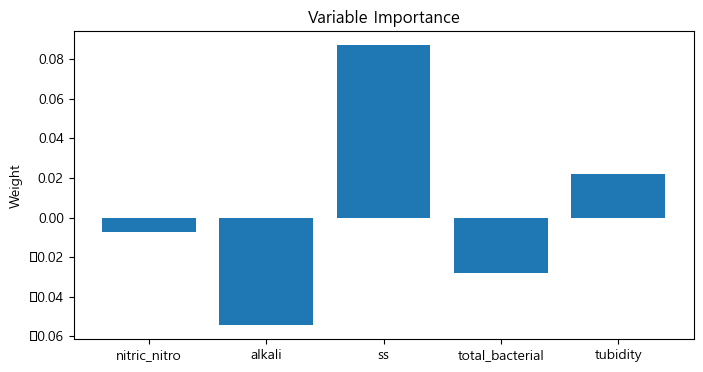

In [10]:
# 가중치를 통해 변수 중요도 획득
weights = model.layers[0].get_weights()[0]
print(weights)


# 변수 중요도 시각화
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(range(feature_number), weights[:, 0])
ax.set_xticks(range(feature_number))
ax.set_xticklabels(feature_Learning)
ax.set_ylabel('Weight')
ax.set_title('Variable Importance')
plt.show()

8/8 [==============================] - 1s 2ms/step


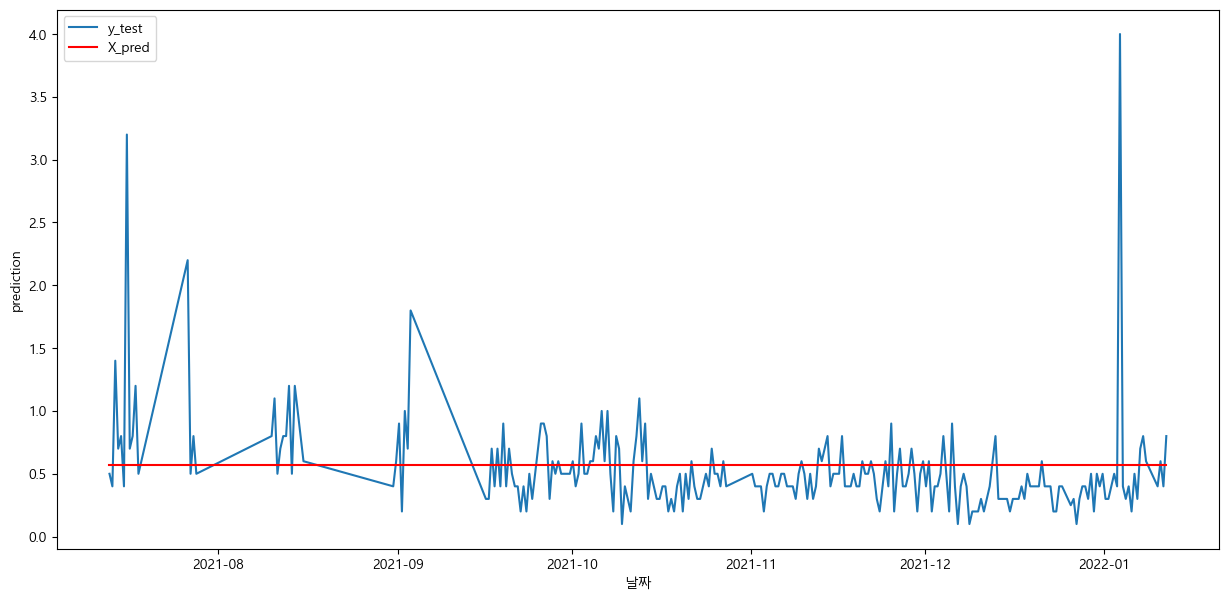

8/8 [==============================] - 1s 3ms/step - loss: 0.1437 - mae: 0.2248 - r_squared: -0.6625
MSE // MAE // R-squared  [0.1437193751335144, 0.22477318346500397, -0.6624876856803894]


In [11]:
grapeNEva(model, japonica_validation_features_X_reshape, japonica_validation_features_y)

In [12]:
# 자포니카 검증 데이터의 한 개 탱크
tank = 1
japonica_validation_features_tank = japonica_validation_features[japonica_validation_features['tank_id']==tank]

# 하루 동안의 데이터 추출
one_day_data = japonica_validation_features_tank.loc['2021-07-13 00:00:00':'2021-07-13 23:59:59']
oneday_X_test = one_day_data[feature_Learning]
oneday_y_test = one_day_data[feature_Target]

oneday_X_test_reshape = np.asarray(oneday_X_test, dtype=np.float64)
oneday_X_test_reshape = oneday_X_test_reshape.reshape((-1, 1, feature_number))

# shape확인
nCar = oneday_X_test_reshape.shape[0] # 데이터 개수
nVar = oneday_X_test_reshape.shape[2] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar = oneday_y_test.shape[0] # 데이터 개수
nVar = oneday_y_test.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 2 nVar: 5
nCar: 2 nVar: 1


1/1 [==============================] - 0s 23ms/step


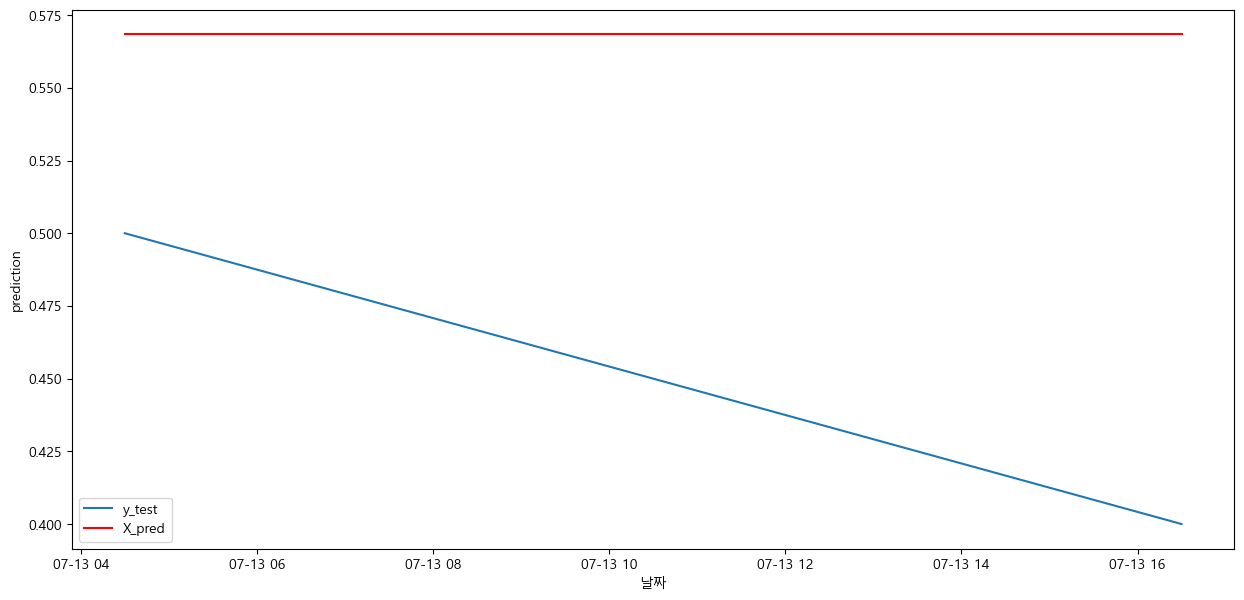

1/1 [==============================] - 0s 27ms/step - loss: 0.0165 - mae: 0.1185 - r_squared: -5.6159
MSE // MAE // R-squared  [0.016540182754397392, 0.1184912770986557, -5.615941524505615]


In [13]:
grapeNEva(model, oneday_X_test_reshape, oneday_y_test)